# CycleGAN to transform focal series into 3D volume. 3D conv + deep structure

## Init

In [1]:
# import tensorflow as tf
# print(tf.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5724176384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4628455239646315591
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



[None]

In [2]:
import os 
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob
import random

import sys 
sys.path.append("..") 


In [3]:
# visualize

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    # plt.title('focal slice')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    # plt.titSle('GT slice')
    plt.show()

## Load data

In [20]:
# generate the gif

import numpy as np
from PIL import Image
import SimpleITK as sitk
import mrcfile

def saveGIF(imageGIF, labelGIF, predict, direction, gif_directory):
    
    # print('during gif') 
    
    imageGIF = imageGIF  # the original dataset is 8 bits
    stack = []
    
    # print(image.shape, label.shape, predict.shape)
    # print('image:', np.max(imageGIF), np.min(imageGIF))
    # print('label after gif: ', np.max(labelGIF), np.min(labelGIF))
    # print('predict: ', np.max(predict), np.min(predict))
    
    bar = np.ones((imageGIF.shape[0], 10)) # divide the images
    
    if direction == 0:
        print('cut along x')
    elif direction == 1:
        print('cut along y')

    elif direction == 2:
        print('cut along z')
        
    else:
        print('please specify the direction')
    
    
    for i in range(imageGIF.shape[0]):

        if direction == 0:
            temp1 = imageGIF[i,...]
            temp2 = predict[i,...]
            temp3 = labelGIF[i,...]
            
        elif direction == 1:
            temp1 = imageGIF[:,i,:]
            temp2 = predict[:,i,:]
            temp3 = labelGIF[:,i,:]
        
        elif direction == 2:
            temp1 = imageGIF[...,i]
            temp2 = predict[...,i]
            temp3 = labelGIF[...,i]
        else:
            print('illegal cut')
        
        
        # print('round:', i)
        # print('image concatenate:', temp1.shape)
        # print('label concatenate:', temp2.shape)
        # print('predict concatenate:', temp3.shape)
        
        imageTemp = np.concatenate((temp1, bar, temp2, bar, temp3), axis=1)
        # print('after concatenate:', imageTemp.shape)
        stack.append(imageTemp)
        
    stack = np.asarray(stack)
    
    # imgs = [img*255 for img in stack]
    imgs = [Image.fromarray(img*255) for img in stack]  # pil要求整体图片乘上255
    # duration is the number of milliseconds between frames; this is 40 frames per second
    imgs[0].save(gif_directory, save_all=True, append_images=imgs[1:], duration=50, loop=0)
    
    # write as nii
    # writer = sitk.ImageFileWriter()
    # writer.SetFileName('./results/result.nii')
    # writer.Execute(stack)
    
    mrc = mrcfile.new('./results/result.mrc', overwrite=True)
    mrc.set_data((stack*255).astype('int8'))
    mrc.close
    
    np.save('./results/result.npy', stack)
    

In [21]:
# specify the dir

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_08/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

num_images = len(train_img_list)
print(num_images)

160


In [22]:
print('image list:', train_img_list[10])
print('mask list:', train_msk_list[10])

image list: E:/EM/demo/3D_Unet_keras/data/2022_08/inputData/train/images\image_110.npy
mask list: E:/EM/demo/3D_Unet_keras/data/2022_08/inputData/train/masks\mask_110.npy


In [24]:
# visualize the images
import random


img_num = random.randint(0, num_images-1) # num从1开始
test_img = np.load(train_img_list[img_num])
test_img = test_img[...,0]
print('image shape:', test_img.shape)

test_mask = np.load(train_msk_list[img_num])
print('before mask:', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)
print('after mask:', test_mask.shape)

image shape: (64, 64, 64)
before mask: (64, 64, 64, 2)
after mask: (64, 64, 64)


In [25]:
#  reshape data for 2D deep UNet

# test = np.stack([test_mask], axis=3)
# print(test.shape)
test = np.expand_dims(test_mask, axis = -1)
print(test.shape)

(64, 64, 64, 1)


current slice: 32


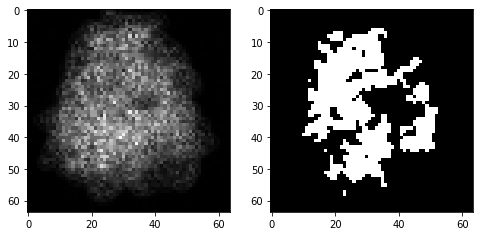

current slice: 34


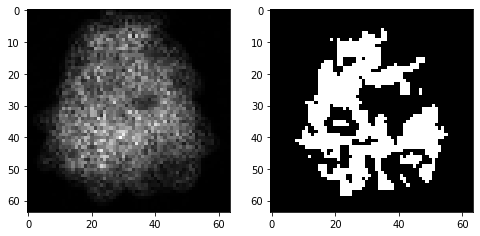

In [26]:
# visualize the images 

# n_slice = random.randint(0, test_mask.shape[2]-1)

n_slice = 32
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

print('current slice:', n_slice + 2)
visusalizeIMG(n_slice + 2, test_img, test_mask)

### Inspect the data balance

In [10]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [11]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

0.54 6.44


## Data generator

In [4]:
# data path and sort

from natsort import natsorted
from dataGenerator import imageLoader3D
from dataGenerator import imageLoader3DIMG, imageLoader3DMSK

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_08/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = natsorted(os.listdir(train_img_dir))
train_msk_list = natsorted(os.listdir(train_msk_dir))

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'

val_img_list = natsorted(os.listdir(val_img_dir))
val_msk_list = natsorted(os.listdir(val_msk_dir))

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'

test_img_list = natsorted(os.listdir(test_img_dir))
test_msk_list = natsorted(os.listdir(test_msk_dir))

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 160
val images: 40
test images: 100


In [5]:
# data generator for training

batch_size = 1

train_img_datagen = imageLoader3DIMG(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

train_msk_datagen = imageLoader3DMSK(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)


# val_img_datagen = imageLoader3D(val_img_dir, val_img_list,
#                              val_msk_dir, val_msk_list, batch_size)

image gen: (1, 64, 64, 64, 1) (1, 64, 64, 64, 1) -0.9999046055458172 0.9260313743965414 -1.0 1.0
(64, 64, 64)
slice num: 60


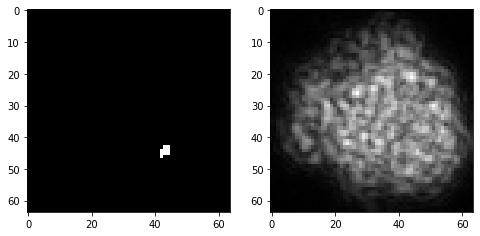

In [6]:
# visualize the data generator

img = train_img_datagen.__next__()
msk = train_msk_datagen.__next__()
print('image gen:', img.shape, msk.shape, img.min(), img.max(), msk.min(), msk.max())

stack_num = random.randint(0, img.shape[0]-1)
test_img = np.squeeze(img[stack_num,...])
test_mask = np.squeeze(msk[stack_num,...])
print(test_img.shape)

n_slice=random.randint(0, test_mask.shape[1]-1)
# n_slice = 50

print('slice num:', n_slice)
visusalizeIMG(n_slice, test_mask, test_img)

## Define model

### Discriminator. 70x70 patch GAN in 3D

In [7]:
from random import random
import numpy as np
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
import tensorflow.keras as k

# use instance normalization as suggested in paper
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import matplotlib.pyplot as plt

In [8]:
# C64-C128-C256-C512
# After last layer, conv to 1-dimension then go through sigmoid
# axis of instancenorm is '-1', ensure features are normalized per feature map

import segmentation_models_3D as sm  # add the BCE to the loss


def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = k.layers.Input(shape=image_shape)
    
    #C64: 4x4 kernel, strides 2x2
    d = k.layers.Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(in_image)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel, strides 2x2
    d = k.layers.Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d) # first norm then activate
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel, strides 2x2
    d = k.layers.Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel, stride 2x2
    # DIY layer,not in original paper
    d = k.layers.Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. kernel 4x4, but stride 1x1
    d = k.layers.Conv3D(512, (4,4,4), strides=(1,1,1), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = k.layers.Conv3D(1, (4,4,4), strides=(1,1,1), padding='same', kernel_initializer=init)(d)
    
    # define model
    model = k.models.Model(in_image, patch_out)
    # compile the model
    # batch size is 1, Adam as opt.
    # loss of D is weighted by 50% of each update. This slows down D's change to G during training
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # DIY loss
    # dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5]))  # default is uniform
    # focal_loss = sm.losses.CategoricalFocalLoss()
    # BCE_loss = sm.losses.BinaryCELoss()
    # total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1  # works for most segmentation jobs

    model.compile(loss='mse', optimizer=opt, loss_weights=[0.5]) 
    return model

Segmentation Models: using `tf.keras` framework.


### Generator. based on resnet

In [9]:
# residual blocks contain two 3x3 Conv with same number of filters in layers

# to release the gradient vanishing and exploding
def resnet_block(n_filters, input_layer):
    # weight init
    init = RandomNormal(stddev=0.02)
    # first conv layer
    g = k.layers.Conv3D(n_filters, (3,3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
#     g = k.layers.ReLU()(g)
    g = k.layers.Activation('relu')(g)  # ??? to layers.ReLU. 只有leaky直接调用，其他的用activation调用
    # second conv layer
    g = k.layers.Conv3D(n_filters, (3,3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    
    # merge channels with input-layer
    g = k.layers.Concatenate()([g, input_layer])
    
    return g

In [10]:
# define G model: unet same structure. the final output is 3 channels for RGB

# c7s1-k: 7x7 Conv -stride 1 -Instancenorm-ReLU -k filters
# dk: 3x3 conv -stride 2 -Instancenorm-ReLU -k filters
# Rk: residual block that contains two 3x3 conv layers
# uk: 3x3 fractional~strided~conv -stride 1/2 -Instancenorm -ReLU -k filters

# two possible structures:
# with 6 res-blocks: c7s1-64, d128, d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3
# with 9 res-blocks: c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape)
    
    # c7s1-64
    g = k.layers.Conv3D(64, (7,7,7), strides=(1,1,1), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d128
    g = k.layers.Conv3D(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d256
    g = k.layers.Conv3D(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    
    # R256. resnet for the gradient. 9 layers
    for _ in range(n_resnet):
        g = resnet_block(256, g)  
    
    # u128
    g = k.layers.Conv3DTranspose(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # u64
    g = k.layers.Conv3DTranspose(64, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    
    # c7s1-3
    # g = k.layers.Conv3D(3, (7,7,7), strides=(1,1,1), padding='same', kernel_initializer=init)(g)
    # c7s1-1 for single channel images
    g = k.layers.Conv3D(1, (7,7,7), strides=(1,1,1), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = k.layers.Activation('tanh')(g)  # roy: 可以用sigmoid激活？
    # define the model
    model = k.models.Model(in_image, out_image)  # generator does not compile
    
    return model

### Compose the model

In [11]:
# define a composite model to update generator wuth adversarial and cycle loss
# only use to train generator
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # use this to train both generators. But one at a time
    # trained G is tranable, others are constant
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # adversarial loss
    input_gen = k.layers.Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    ouput_d = d_model(gen1_out)
    # identity loss
    input_id = k.layers.Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle-loss forward
    output_f = g_model_2(gen1_out)
    # cycle-loss backward
    gen2_out = g_model_2(input_id)  # ???
    output_b = g_model_1(gen2_out)
    
    # define the model graph
    model = k.models.Model([input_gen, input_id], [ouput_d, output_id, output_f, output_b])
    
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # loss for the cycleGAN model
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1,5,10,10], optimizer=opt) # hyper param from paper
    return model


#### 检查网络的结构形状

In [6]:
# 检查输入输出的形状

# define hyper param and intance of model in cycleGAN
image_shape = [64,64,64,1]
# generator A->B
g_test_AtoB = define_generator(image_shape)
# generator B->A
g_test_BtoA = define_generator(image_shape)
# D: A-> [real/ fake]
d_test_A = define_discriminator(image_shape)
# D: B-> [real/fake]
d_test_B = define_discriminator(image_shape)
# composite: A->B->[real/fake, A]
c_test_AtoB = define_composite_model(g_test_AtoB, d_test_B, g_test_BtoA, image_shape)
# composite: B->A->[real/fake, B]
c_test_BtoA = define_composite_model(g_test_BtoA, d_test_A, g_test_AtoB, image_shape)

D:\INSTALL\Anaconda\envs\EM\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
print(c_test_AtoB.input_shape, c_test_AtoB.output_shape)
print(c_test_BtoA.input_shape, c_test_BtoA.output_shape)
print('discriminator:', d_test_A.input_shape, d_test_A.output_shape, d_test_B.output_shape)
print(d_test_A.output_shape[1])

[(None, 64, 64, 64, 1), (None, 64, 64, 64, 1)] [(None, 4, 4, 4, 1), (None, 64, 64, 64, 1), (None, 64, 64, 64, 1), (None, 64, 64, 64, 1)]
[(None, 64, 64, 64, 1), (None, 64, 64, 64, 1)] [(None, 4, 4, 4, 1), (None, 64, 64, 64, 1), (None, 64, 64, 64, 1), (None, 64, 64, 64, 1)]
discriminator: (None, 64, 64, 64, 1) (None, 4, 4, 4, 1) (None, 4, 4, 4, 1)
4


In [22]:
# 测试训练过程的数据形状
n_patch = d_test_A.output_shape[1]
n_batch = 1
trainA = np.random.randn(260,64,64,64,1)
trainB = trainA
print(trainA.shape)
# trainA, trainB = dataset
X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
print(X_realA.shape, y_realA.shape, X_realB.shape, y_realB.shape)

(260, 64, 64, 64, 1)
(1, 64, 64, 64, 1) (1, 4, 4, 4, 1) (1, 64, 64, 64, 1) (1, 4, 4, 4, 1)


In [26]:
# 测试训练的单步

X_fakeA, y_fakeA = generate_fake_samples(g_test_BtoA, X_realB, n_patch)
X_fakeB, y_fakeB = generate_fake_samples(g_test_AtoB, X_realA, n_patch)

1/1 [==============================] - 1s 588ms/step


In [27]:
print(X_fakeA.shape, y_fakeA.shape)

(1, 64, 64, 64, 1) (1, 4, 4, 4, 1)


In [ ]:
g_loss2, _, _, _, _ = c_test_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
dA_loss1 = d_test_A.train_on_batch(X_realA, y_realA)
dA_loss2 = d_test_A.train_on_batch(X_fakeA, y_fakeA)  # since batch is 1, cannot split into half for real/fale

print(dA_loss1, dA_loss2, g_loss2)

In [19]:
X_realA, y_realA = generate_real_samples('mask', 4)
print(X_realA.shape, y_realA.shape, X_realA.max(), X_realA.min())

(1, 64, 64, 64, 1) (1, 4, 4, 4, 1) 1.0 -1.0


#### Processing images

In [12]:
# load and prepare traning images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1-127.5)/127.5
    X2 = (X2-127.5)/127.5
    return [X1, X2]

# D needs fake and real images
# select batch of samples, return images and target.
# real images the label is '1'
def generate_real_samples(DOMAIN, patch_shape, batch_size=1):
    # ix = randint(0, dataset.shape[0], n_samples)
    # X = dataset[ix]
    
    if DOMAIN == 'image':
        X = train_img_datagen.__next__() 
    elif DOMAIN == 'mask':
        X = train_msk_datagen.__next__()
    else:
        print('illegal domain')
    
    # generate the 'real' class label
    y = np.ones((batch_size, patch_shape, patch_shape, patch_shape, 1)) # in th same size of one channel. change into 3D
    return X, y

# fake images with label '0'
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    # y = np.zeros((len(X), patch_shape, patch_shape, 1))
    y = np.zeros((len(X), patch_shape, patch_shape, patch_shape, 1))  # into 3D
    return X, y

# save model
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator models
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))  

In [13]:
# predict images with save model, plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # sample input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale pixels from [-1,1] to [0,1]
    X_in = (X_in + 1)/2
    X_out = (X_out + 1)/2
    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i)
        plt.axis('off')
        plt.imshow(X_in[i])
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i+n_samples)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()
        

In [14]:
# update fake images pool to avoid model oscillation
# update D using a history of generated images rather than latest generators
# image buffer is 50

from random import random

def update_image_pool(pool, images, max_size=20):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # weird, must indicate the package name
            # use images, but don't add it into pool
            selected.append(image)
        else:
            # replace exiting images and use replaced 
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    out = np.asarray(selected)  # transfer into array
    return out

#### training process

In [28]:
# train cyclegan
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, train_img_list, epochs=1):
    # training hyper param
    n_epochs, n_batch = epochs, 1 # batch_size is fixed into 1
    # output square shape of D
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    # trainA, trainB = dataset
    
    # image pool for fake images
    poolA, poolB = list(), list()
    # number of batches per training epoch
    bat_per_epo = int(len(train_img_list) / n_batch)
    # training iterations
    n_steps = bat_per_epo * n_epochs
    
    # enumerate epochs
    for i in range(n_steps):
        # for every iteration/ batch
        # sample real images from both domain
        X_realA, y_realA = generate_real_samples('image', n_patch, batch_size=1)  # A domain: image
        X_realB, y_realB = generate_real_samples('mask', n_patch, batch_size=1)  # B domain: mask
        
        # generate fake images for both (A2B, B2A)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        
        # update the fake images in the pool as buffer with 50 images. tricks for model collapsing
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # update G-B2A via composite model
        # this is the combine model: G1 + G2 + D
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update D for A->[real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)  # since batch is 1, cannot split into half for real/fale
        
        # update G-A2B via composite model
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # summarize the performance
        # batch size is 1, iteration is same as dataset
        # if there are 100 images, then 1 epoch will be 100 iterations
        print('Iterations>%d, dA[%.3f, %3.f] dB[%.3f,%.3f] g[%.3f, %.3f]'% (i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
        
        # evaluate performance periodically
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'A2B')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'B2A')
        
        # save model every 5 batches
        if (i+1) % (bat_per_epo * 5) == 0:
            # if batch size(total images)=100, model saved after every 75th * 5 = 375 iter 
            save_models(i, g_model_AtoB, g_model_BtoA)
            

### Traning

In [17]:
test = train_img_datagen.__next__()

image_shape = test.shape[1:]
print(image_shape)

(64, 64, 64, 1)


In [19]:
# define hyper param and intance of model in cycleGAN
image_shape = test.shape[1:]
# generator A->B
g_model_AtoB = define_generator(image_shape)
# generator B->A
g_model_BtoA = define_generator(image_shape)
# D: A-> [real/ fake]
d_model_A = define_discriminator(image_shape)
# D: B-> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A->B->[real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B->A->[real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


D:\INSTALL\Anaconda\envs\EM\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Training process

In [ ]:
# training

from datetime import datetime
start1 = datetime.now()
# train model
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, train_img_list, epochs=1)

stop1 = datetime.now()

In [ ]:
# execustion time
execution_time = stop1 - start1
print('Executed time: ', execution_time)

### Testing. load trained model

In [19]:
# use the saved cycleGAN for image translation
from keras.models import load_model

In [20]:
# select random samples from dataset
def select_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X

In [21]:
# plot the image, translation and reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = np.vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot the images
    for i in range(len(images)):
        plt.subplot(1, len(images), 1+i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()
    

In [22]:
# loading the test dataset
A_data = X_test  # focal
B_data = Y_test  # volume

predict_data = [A_data, B_data]

predict_data = preprocess_data(predict_data)  # re-scale and pre-processing
print('focal dataset: ', predict_data[0].shape)
print('volume dataset: ', predict_data[1].shape)

focal dataset:  (256, 256, 256, 3)
volume dataset:  (256, 256, 256, 3)


In [23]:
# # load dataset
# A_data = resample(dataA_all, replace=False, n_samples=50, random_state=42)
# B_data = resample(dataB_all, replace=False, n_samples=50, random_state=42)

# A_data = (A_data - 127.5) / 127.5
# B_data = (B_data - 127.5) / 127.5

In [27]:
# load models
cust = {'InstanceNormalization': InstanceNormalization}  # !!! the lcoal normalization 
model_AtoB = load_model('./cycleGAN/model/g_model_AtoB_028160.h5', cust)
model_BtoA1 = load_model('./cycleGAN/model/g_model_BtoA_028160.h5', cust)
model_BtoA2 = load_model('./cycleGAN/model/g_model_BtoA_025600.h5', cust)

In [25]:
# prediction of the results
B_generated  = model_AtoB.predict(predict_data[0])  # transfer focal > volume
A_generated1  = model_BtoA1.predict(predict_data[1])  # volume > focal
A_generated2  = model_BtoA2.predict(predict_data[1])  # volume > focal

In [26]:
# check the generated volume and original volume

import napari

viewer1 = napari.view_image(B_generated)  # generated volume
napari.run() 
viewer2 = napari.view_image(predict_data[1])  
napari.run() 


In [28]:
# check the generated focal and original focal

import napari

viewer1 = napari.view_image(A_generated1)  # generated focal-28160 model
napari.run() 
viewer2 = napari.view_image(A_generated2)  # generated focal-25600 model
napari.run() 
viewer3 = napari.view_image(predict_data[0])  
napari.run() 